## Import Necessary Libraries

In [34]:
import pandas as pd # for data manipulation
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting
import numpy as np # for numerical operations
import cv2 # for image processing
import random # for random operations
import os # for file operations

## Data Loading & Basic Stats

In [35]:
df = pd.read_csv('dataset/Facial Skin Condition Dataset.csv') #loading the dataset
df.head() #displaying first 5 rows

,id,gender,image front,image right side,image left side
0,1,male,1/front.png,1/right-side.png,1/left-side.png
1,2,female,2/front.png,2/right-side.png,2/left-side.png
2,3,female,3/front.png,3/right-side.png,3/left-side.png
3,4,female,4/front.png,4/right-side.png,4/left-side.png
4,5,male,5/front.png,5/right-side.png,5/left-side.png


In [36]:
df.shape #How many rows and colums

(15, 5)

In [37]:
df.info() #obtaining summary information about the dataset

<class 'pandas.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   id                15 non-null     int64
 1   gender            15 non-null     str  
 2   image front       15 non-null     str  
 3   image right side  15 non-null     str  
 4   image left side   15 non-null     str  
dtypes: int64(1), str(4)
memory usage: 732.0 bytes


In [38]:
df.dtypes #checking the datatypes of each column

id                  int64
gender                str
image front           str
image right side      str
image left side       str
dtype: object

In [39]:
# Check missing values
df.isnull().sum()

id                  0
gender              0
image front         0
image right side    0
image left side     0
dtype: int64

## Image Loading and Feature Extraction

In [ ]:
# STEP 1: Define Base Path 
base_path = "dataset"

# STEP 2: Initialize Empty Lists
image_paths = []
image_types = []
ids = []
genders = []

# STEP 3: Iterate Through DataFrame

for index, row in df.iterrows():
    folder = str(row['id'])
    gender = row['gender']
    
    folder_path = os.path.join(base_path, folder)
    
    views = {"front":"front.jpg","left":"left-side.jpg","right":"right-side.jpg"}
    
    for view, filename in views.items():
        img_path = os.path.join(folder_path, filename)
        if os.path.exists(img_path):
            image_paths.append(img_path)
            image_types.append(view)
            ids.append(folder)
            genders.append(gender)

print("Total images loaded:", len(image_paths))

# STEP 4: Create Image DataFrame

image_df = pd.DataFrame({
    "id": ids,
    "gender": genders,
    "view": image_types,
    "path": image_paths
})

# STEP 5: Compute Image Features

# Initialize feature storage lists
widths, heights = [], []
brightness_list, blur_list = [], []
r_mean, g_mean, b_mean = [], [], []

# Loop through each image path to extract features
for path in image_df['path']:
    img = cv2.imread(path)   # Read image using OpenCV
    
    # Extract image dimensions
    h, w = img.shape[:2]
    widths.append(w)
    heights.append(h)
    
    # Compute overall brightness (mean pixel intensity)
    brightness_list.append(np.mean(img))
    
    # Convert to grayscale for blur detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Compute blur score using variance of Laplacian
    # Higher value = sharper image
    blur_list.append(cv2.Laplacian(gray, cv2.CV_64F).var())
    
    # Convert BGR to RGB for color feature extraction
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Compute mean intensity for each color channel
    r_mean.append(np.mean(img_rgb[:, :, 0]))
    g_mean.append(np.mean(img_rgb[:, :, 1]))
    b_mean.append(np.mean(img_rgb[:, :, 2]))


# STEP 6: Add Features to DataFrame
image_df['width'] = widths
image_df['height'] = heights
image_df['aspect_ratio'] = image_df['width'] / image_df['height']
image_df['brightness'] = brightness_list
image_df['blur'] = blur_list
image_df['r_mean'] = r_mean
image_df['g_mean'] = g_mean
image_df['b_mean'] = b_mean

# Display first few rows
image_df.head()

Total images loaded: 45


,id,gender,view,path,width,height,aspect_ratio,brightness,blur,r_mean,g_mean,b_mean
0,1,male,front,dataset\1\front.jpg,960,1280,0.750000,92.359382,64.591037,105.987198,91.266632,79.824316
1,1,male,left,dataset\1\left-side.jpg,960,1280,0.750000,78.949399,145.159682,88.857800,79.027437,68.962959
2,1,male,right,dataset\1\right-side.jpg,960,1280,0.750000,81.099603,103.965441,91.353083,81.214479,70.731247
3,2,female,front,dataset\2\front.jpg,613,1280,0.478906,81.622582,380.067135,96.419750,73.623487,74.824509
4,2,female,left,dataset\2\left-side.jpg,613,1280,0.478906,75.598583,273.614951,89.737515,69.706163,67.352071


#  Dataset Distribution by View and Gender 

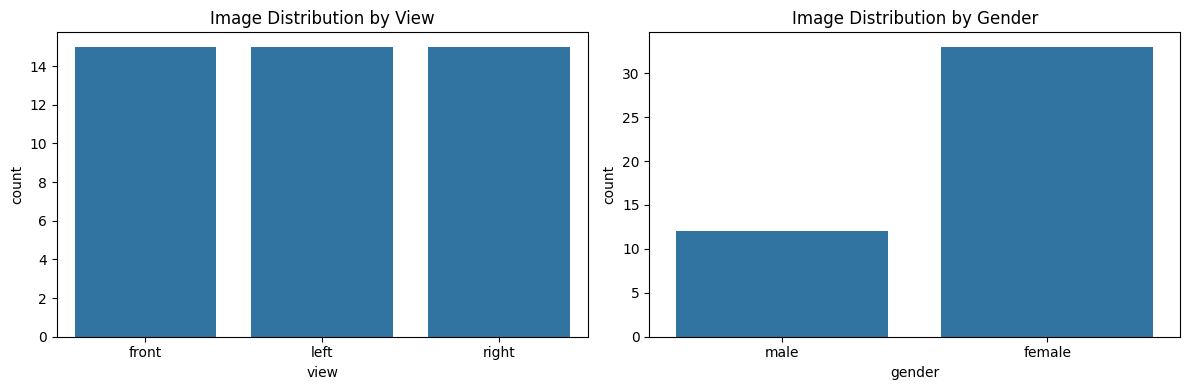

In [41]:

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(x='view', data=image_df, ax=axes[0])
axes[0].set_title('Image Distribution by View')
sns.countplot(x='gender', data=image_df, ax=axes[1])
axes[1].set_title('Image Distribution by Gender')
plt.tight_layout()
plt.show()

 # Image Dimensions Analysis (Scatter + Marginal histograms)

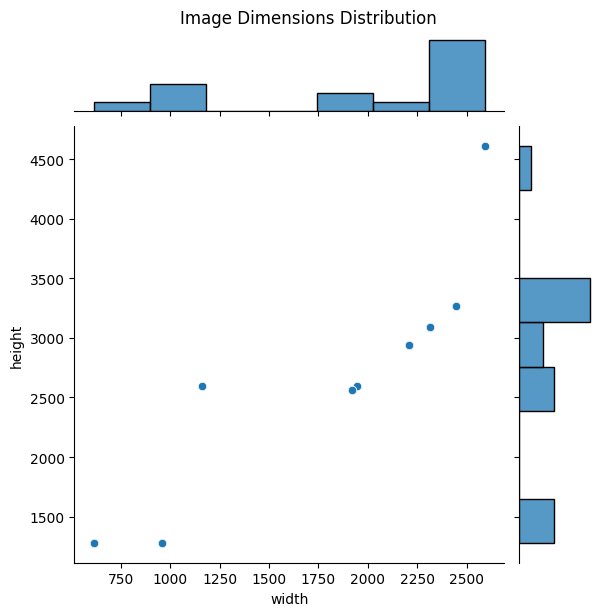

In [42]:
g = sns.JointGrid(data=image_df, x='width', y='height')
g.plot(sns.scatterplot, sns.histplot)
g.fig.suptitle('Image Dimensions Distribution', y=1.02)
plt.show()

# Brightness Distribution by View and Gender

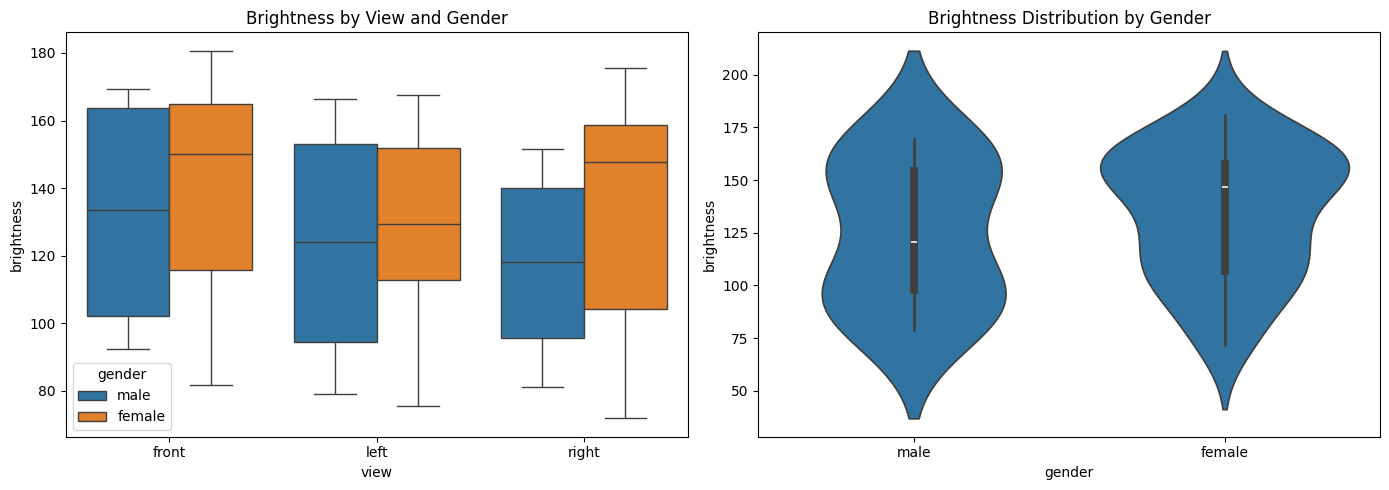

In [43]:

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(x='view', y='brightness', hue='gender', data=image_df, ax=axes[0])
axes[0].set_title('Brightness by View and Gender')
sns.violinplot(x='gender', y='brightness', data=image_df, ax=axes[1])
axes[1].set_title('Brightness Distribution by Gender')
plt.tight_layout()
plt.show()

# Image Quality Analysis (Blur Detection)

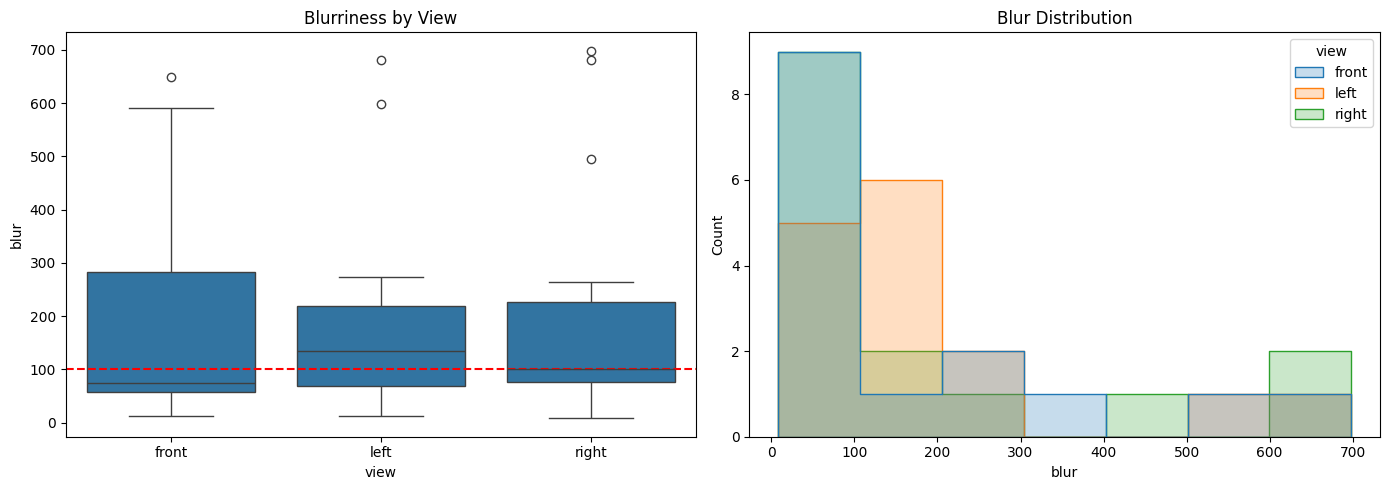

In [44]:

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(x='view', y='blur', data=image_df, ax=axes[0])
axes[0].set_title('Blurriness by View')
axes[0].axhline(y=100, color='r', linestyle='--', label='Acceptable blur threshold')
sns.histplot(data=image_df, x='blur', hue='view', element='step', ax=axes[1])
axes[1].set_title('Blur Distribution')
plt.tight_layout()
plt.show()

#  Color Channel Analysis (RGB distributions)

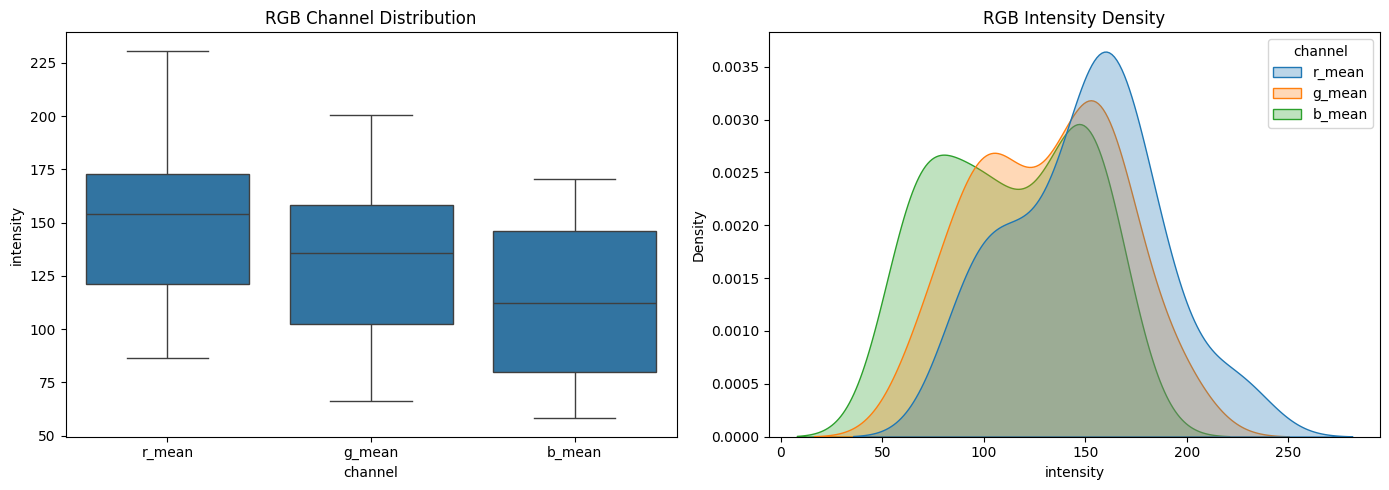

In [45]:

rgb_melted = image_df.melt(value_vars=['r_mean','g_mean','b_mean'], 
                           var_name='channel', value_name='intensity')
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(x='channel', y='intensity', data=rgb_melted, ax=axes[0])
axes[0].set_title('RGB Channel Distribution')
sns.kdeplot(data=rgb_melted, x='intensity', hue='channel', fill=True, alpha=0.3, ax=axes[1])
axes[1].set_title('RGB Intensity Density')
plt.tight_layout()
plt.show()

# Color Temperature Analysis

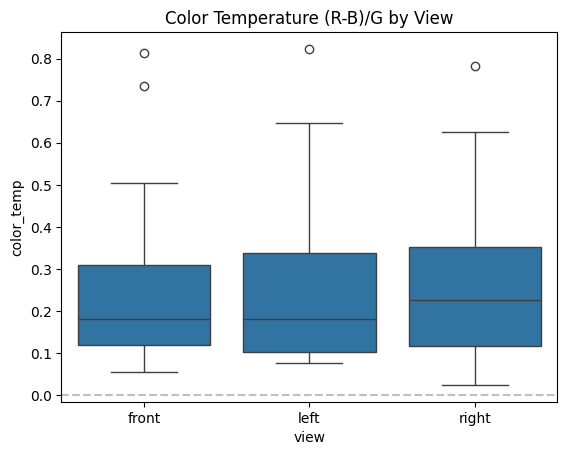

In [46]:

image_df['color_temp'] = (image_df['r_mean'] - image_df['b_mean']) / (image_df['g_mean'] + 1)
sns.boxplot(x='view', y='color_temp', data=image_df)
plt.title('Color Temperature (R-B)/G by View')
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.show()

#  Aspect Ratio Distribution

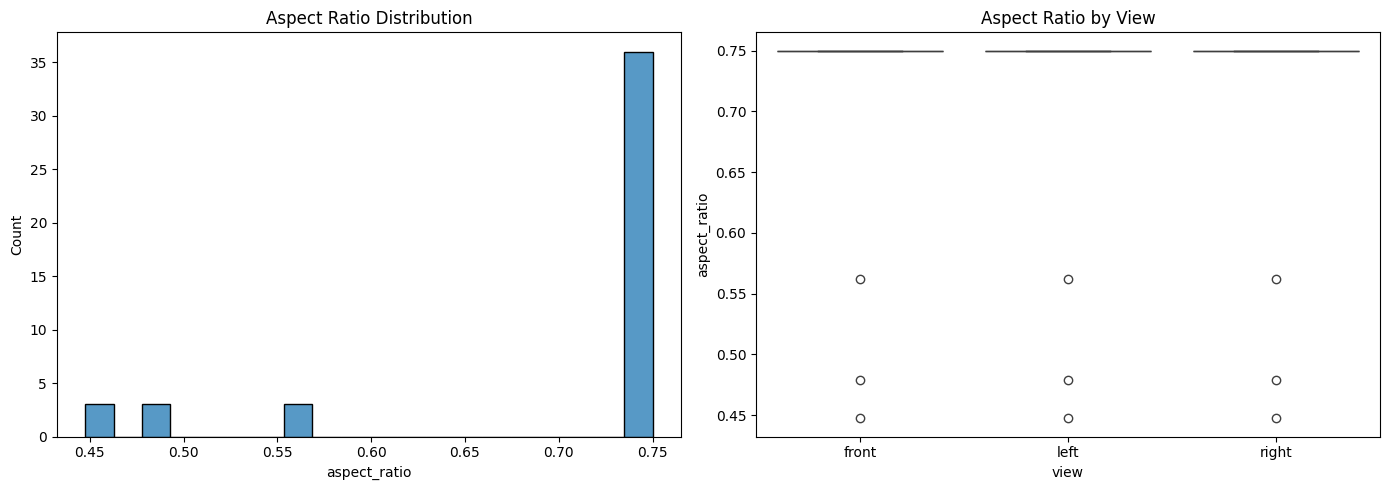

In [47]:

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(image_df['aspect_ratio'], bins=20, ax=axes[0])
axes[0].set_title('Aspect Ratio Distribution')
sns.boxplot(x='view', y='aspect_ratio', data=image_df, ax=axes[1])
axes[1].set_title('Aspect Ratio by View')
plt.tight_layout()
plt.show()

# Feature Correlation Matrix

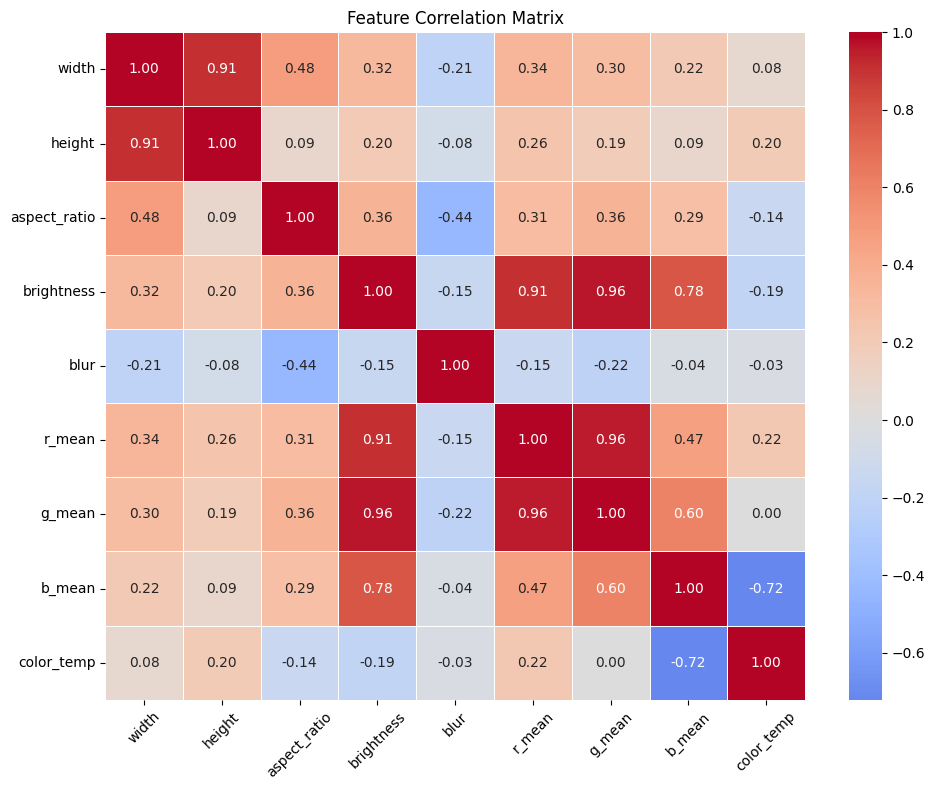

In [48]:

numeric_cols = image_df.select_dtypes(include='number').columns
corr_matrix = image_df[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    center=0,
    fmt=".2f",
    linewidths=0.5
)

plt.title("Feature Correlation Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# PCA for Dimensionality Reduction

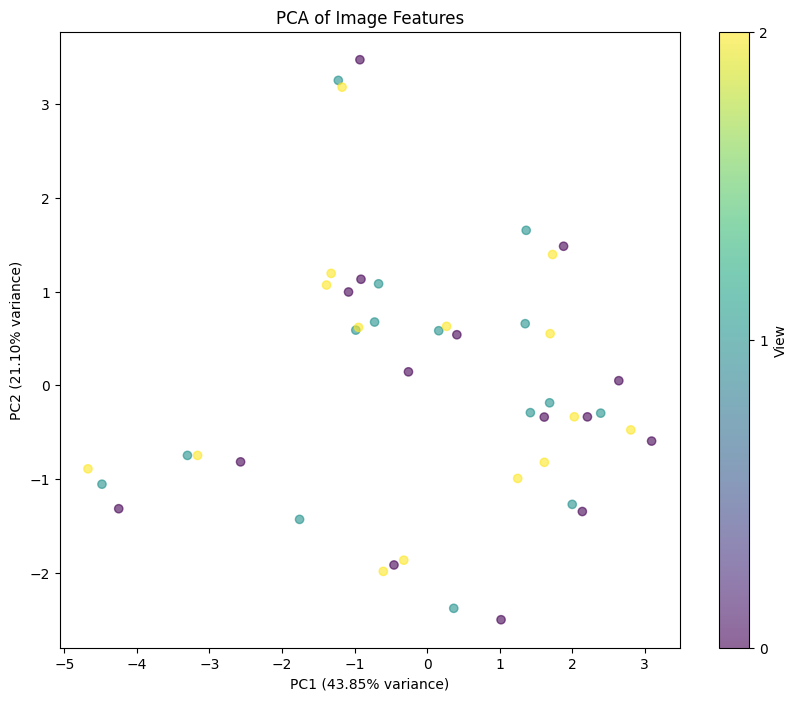

In [49]:

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

features = image_df[numeric_cols].dropna()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], 
                     c=pd.factorize(image_df['view'])[0], 
                     cmap='viridis', alpha=0.6)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('PCA of Image Features')
plt.colorbar(scatter, ticks=[0, 1, 2], label='View')
plt.show()

# Explained Variance Ratio (Scree plot)

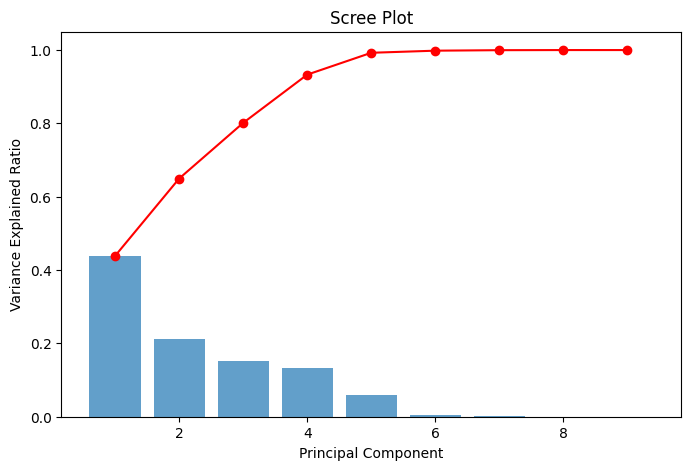

In [50]:

pca_full = PCA()
pca_full.fit(scaled_features)
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(pca_full.explained_variance_ratio_)+1), 
        pca_full.explained_variance_ratio_, alpha=0.7)
plt.plot(range(1, len(pca_full.explained_variance_ratio_)+1), 
         np.cumsum(pca_full.explained_variance_ratio_), 'ro-')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained Ratio')
plt.title('Scree Plot')
plt.show()

#  Image Quality Metrics by ID (consistency per person)

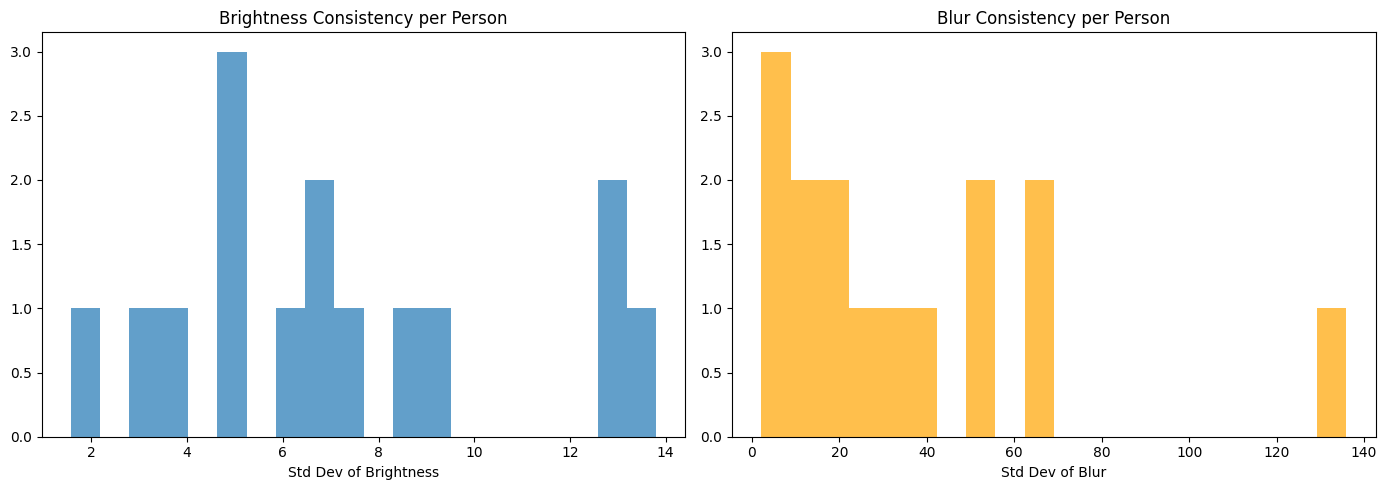

In [51]:

per_person_quality = image_df.groupby('id').agg({
    'brightness': 'std',
    'blur': 'std'
}).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(per_person_quality['brightness'], bins=20, alpha=0.7)
axes[0].set_title('Brightness Consistency per Person')
axes[0].set_xlabel('Std Dev of Brightness')
axes[1].hist(per_person_quality['blur'], bins=20, alpha=0.7, color='orange')
axes[1].set_title('Blur Consistency per Person')
axes[1].set_xlabel('Std Dev of Blur')
plt.tight_layout()
plt.show()



# Scatter: Width vs Height (size relationships)

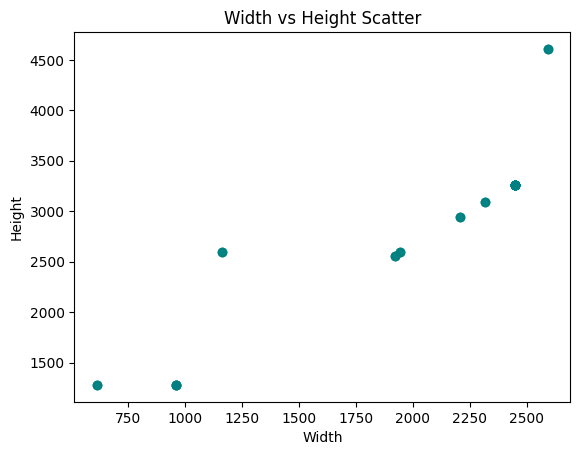

In [52]:

plt.figure()
plt.scatter(image_df['width'], image_df['height'], c='teal', alpha=0.7)
plt.title("Width vs Height Scatter")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()

# Boxplot: Aspect ratio by gender

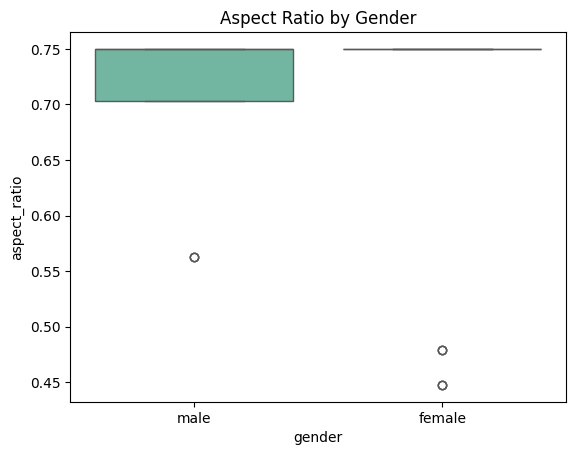

In [53]:
sns.boxplot(x='gender', y='aspect_ratio', data=image_df, hue='gender', palette='Set2', dodge=False)
plt.title("Aspect Ratio by Gender")
plt.legend([],[], frameon=False)  # Hide extra legend
plt.show()

#  Scatter: Aspect ratio vs Brightness

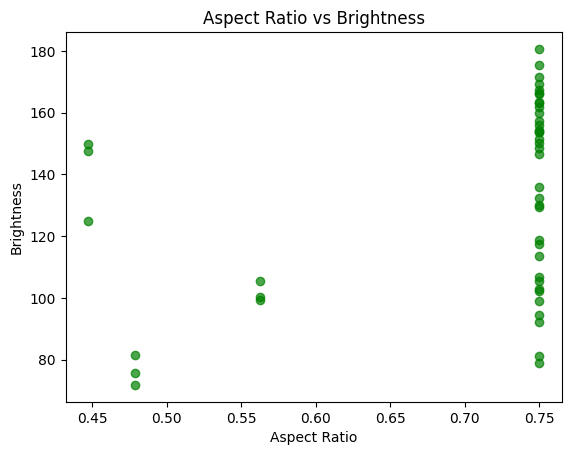

In [54]:

plt.figure()
plt.scatter(image_df['aspect_ratio'], image_df['brightness'], c='green', alpha=0.7)
plt.title("Aspect Ratio vs Brightness")
plt.xlabel("Aspect Ratio")
plt.ylabel("Brightness")
plt.show()

# KDE jointplot: Brightness vs Blur

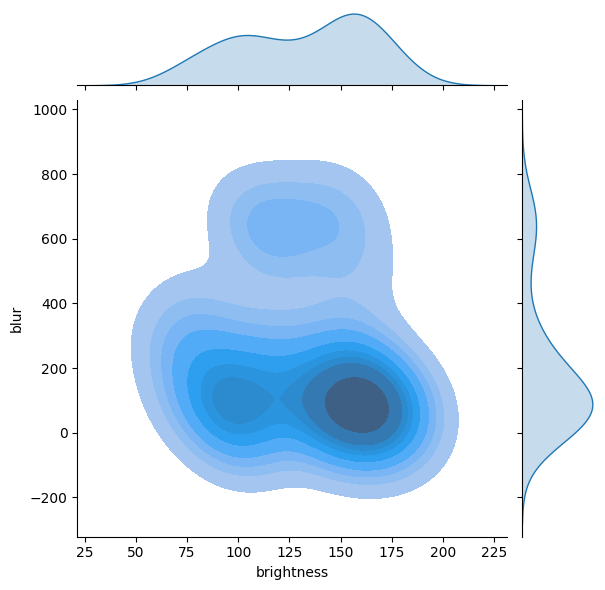

In [55]:

sns.jointplot(data=image_df, x='brightness', y='blur', kind='kde', fill=True)
plt.show()

#  Swarm plot: Aspect ratio by view

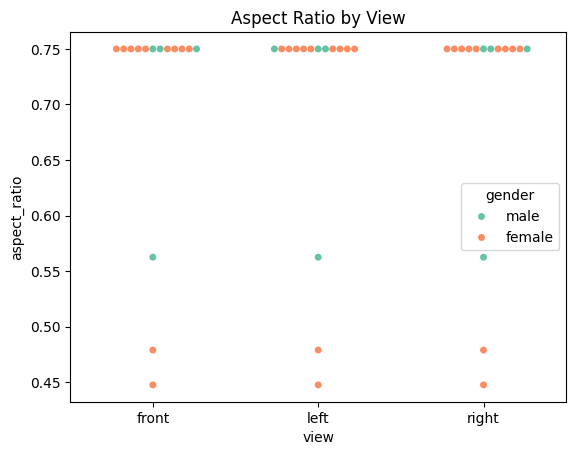

In [56]:
sns.swarmplot(x='view', y='aspect_ratio', data=image_df, hue='gender',palette='Set2', dodge=False)
plt.title("Aspect Ratio by View")
plt.show()

#  KDE: Aspect ratio distribution

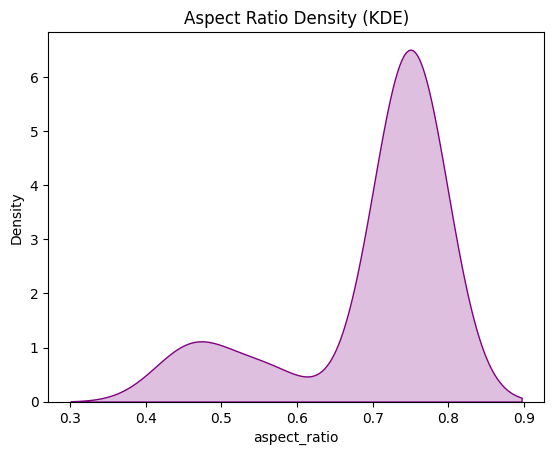

In [57]:

sns.kdeplot(image_df['aspect_ratio'], fill=True, color='purple')
plt.title("Aspect Ratio Density (KDE)")
plt.show()

#  RGB scatter

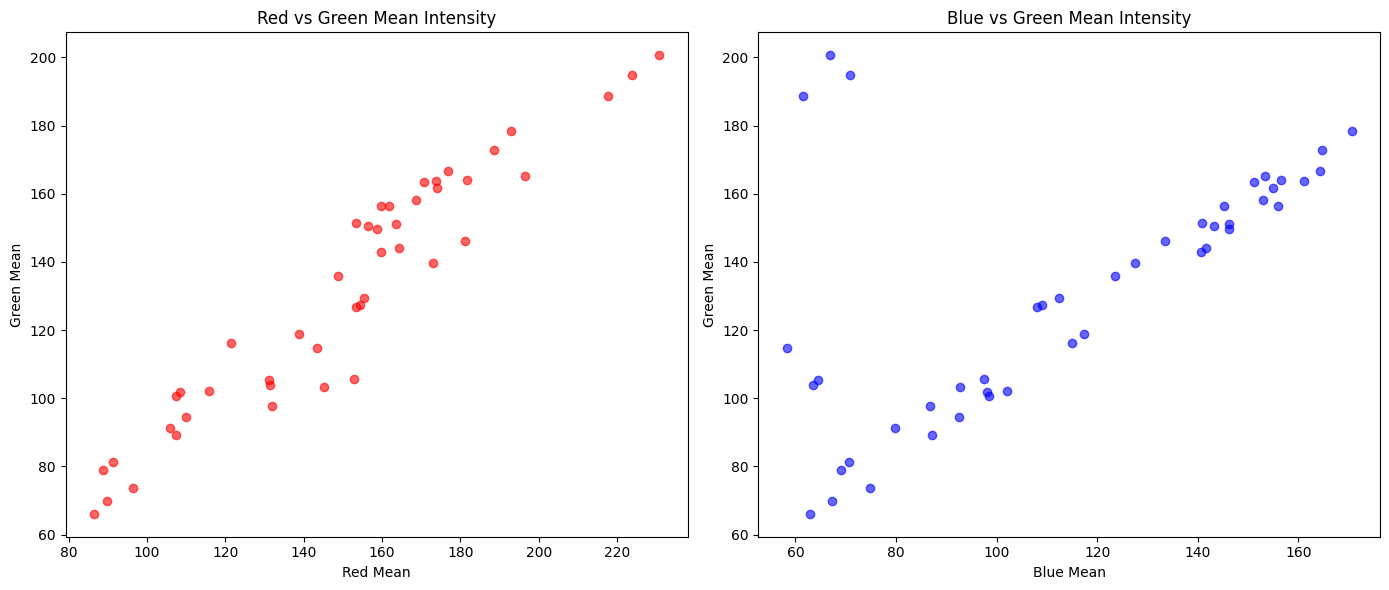

In [58]:

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: Red vs Green
axes[0].scatter(image_df['r_mean'], image_df['g_mean'], c='red', alpha=0.6)
axes[0].set_title("Red vs Green Mean Intensity")
axes[0].set_xlabel("Red Mean")
axes[0].set_ylabel("Green Mean")

# Right plot: Blue vs Green
axes[1].scatter(image_df['b_mean'], image_df['g_mean'], c='blue', alpha=0.6)
axes[1].set_title("Blue vs Green Mean Intensity")
axes[1].set_xlabel("Blue Mean")
axes[1].set_ylabel("Green Mean")

# Adjust layout and display
plt.tight_layout()
plt.show()

# KDE: Brightness distribution

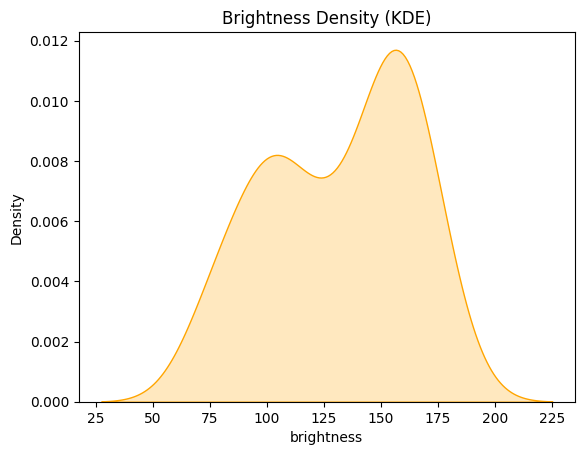

In [59]:

sns.kdeplot(image_df['brightness'], fill=True, color='orange')
plt.title("Brightness Density (KDE)")
plt.show()



# Violin plot: Blur by view

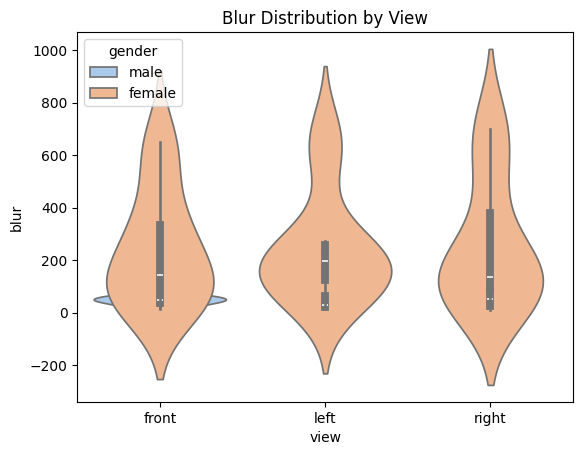

In [60]:
sns.violinplot(x='view', y='blur', data=image_df, hue='gender',palette='pastel', dodge=False)
plt.title("Blur Distribution by View")
plt.show()

#  Pairplot of numeric features colored by view

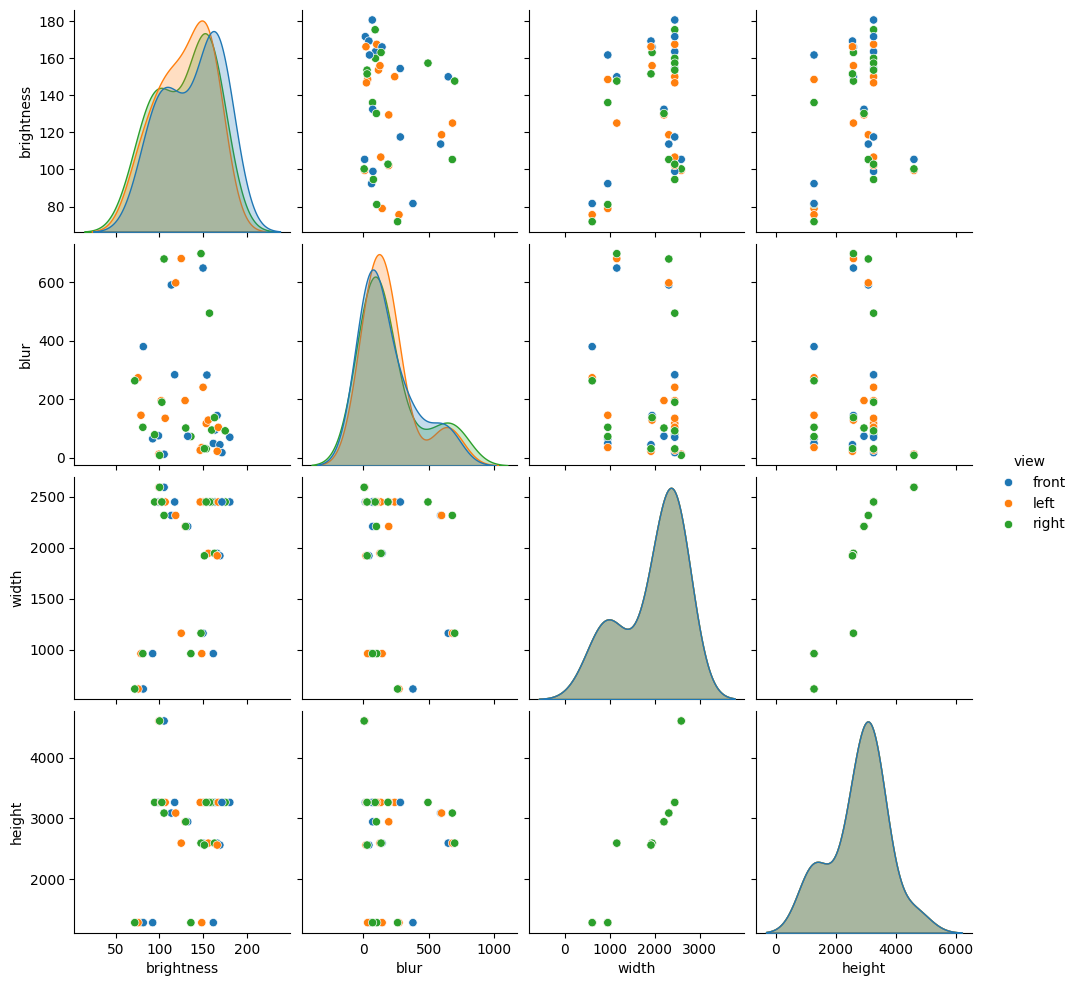

In [61]:
sns.pairplot(image_df[['brightness','blur','width','height','view']], hue='view')
plt.show()

# Image grid: 9 random images

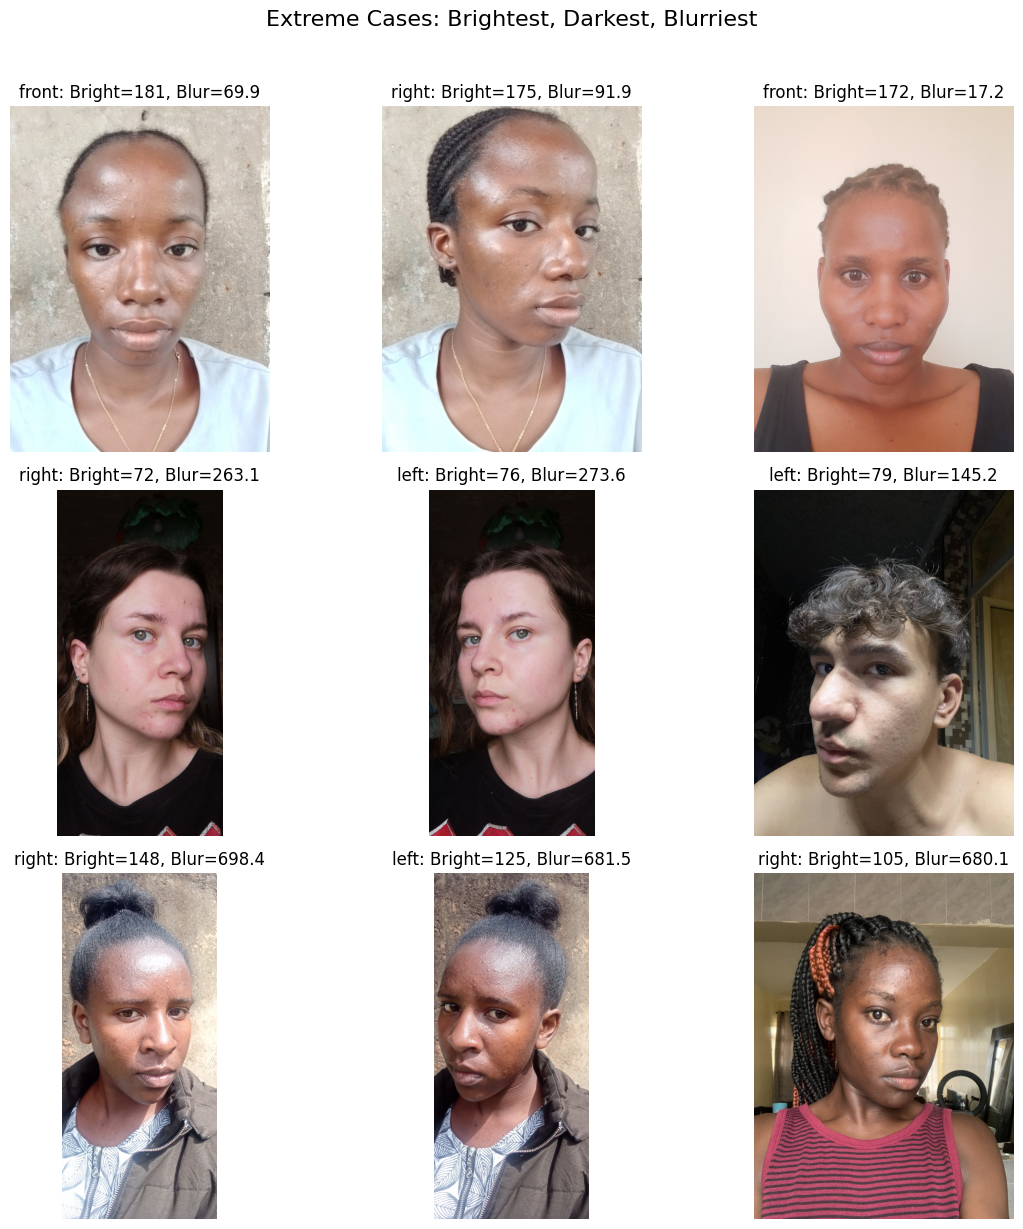

In [62]:
# 19. Extreme Cases Analysis (Brightest/Darkest/Blurriest images)
extreme_cases = pd.concat([
    image_df.nlargest(3, 'brightness'),
    image_df.nsmallest(3, 'brightness'),
    image_df.nlargest(3, 'blur')
])

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for idx, (_, row) in enumerate(extreme_cases.iterrows()):
    if idx < 9:
        img = cv2.imread(row['path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax = axes[idx // 3, idx % 3]
        ax.imshow(img)
        ax.set_title(f"{row['view']}: Bright={row['brightness']:.0f}, Blur={row['blur']:.1f}")
        ax.axis('off')
plt.suptitle('Extreme Cases: Brightest, Darkest, Blurriest', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

